
 MEDICAL CHATBOT DATASET - CLASSIFICATION MODEL

 MEDICAL CHATBOT DATASET LOADER

 Dataset loaded successfully!

 DATASET STRUCTURE:
   Shape: (47603, 4)
   Columns: ['short_question', 'short_answer', 'tags', 'label']

 DATA TYPES:
short_question     object
short_answer       object
tags               object
label             float64
dtype: object

 FIRST 5 ROWS:
                                      short_question  \
0  can an antibiotic through an iv give you a ras...   
1  can you test positive from having the hep b va...   
2  what are the dietary restrictions for celiac d...   
3  can i transmit genital warts seventeen years a...   
4                          is all vitamin d the same   

                                        short_answer                   tags  \
0  yes it can even after you have finished the pr...  ['rash' 'antibiotic']   
1  test positive for what if you had a hep b vacc...        ['hepatitis b']   
2  omitting gluten from the diet is the key to co...     ['

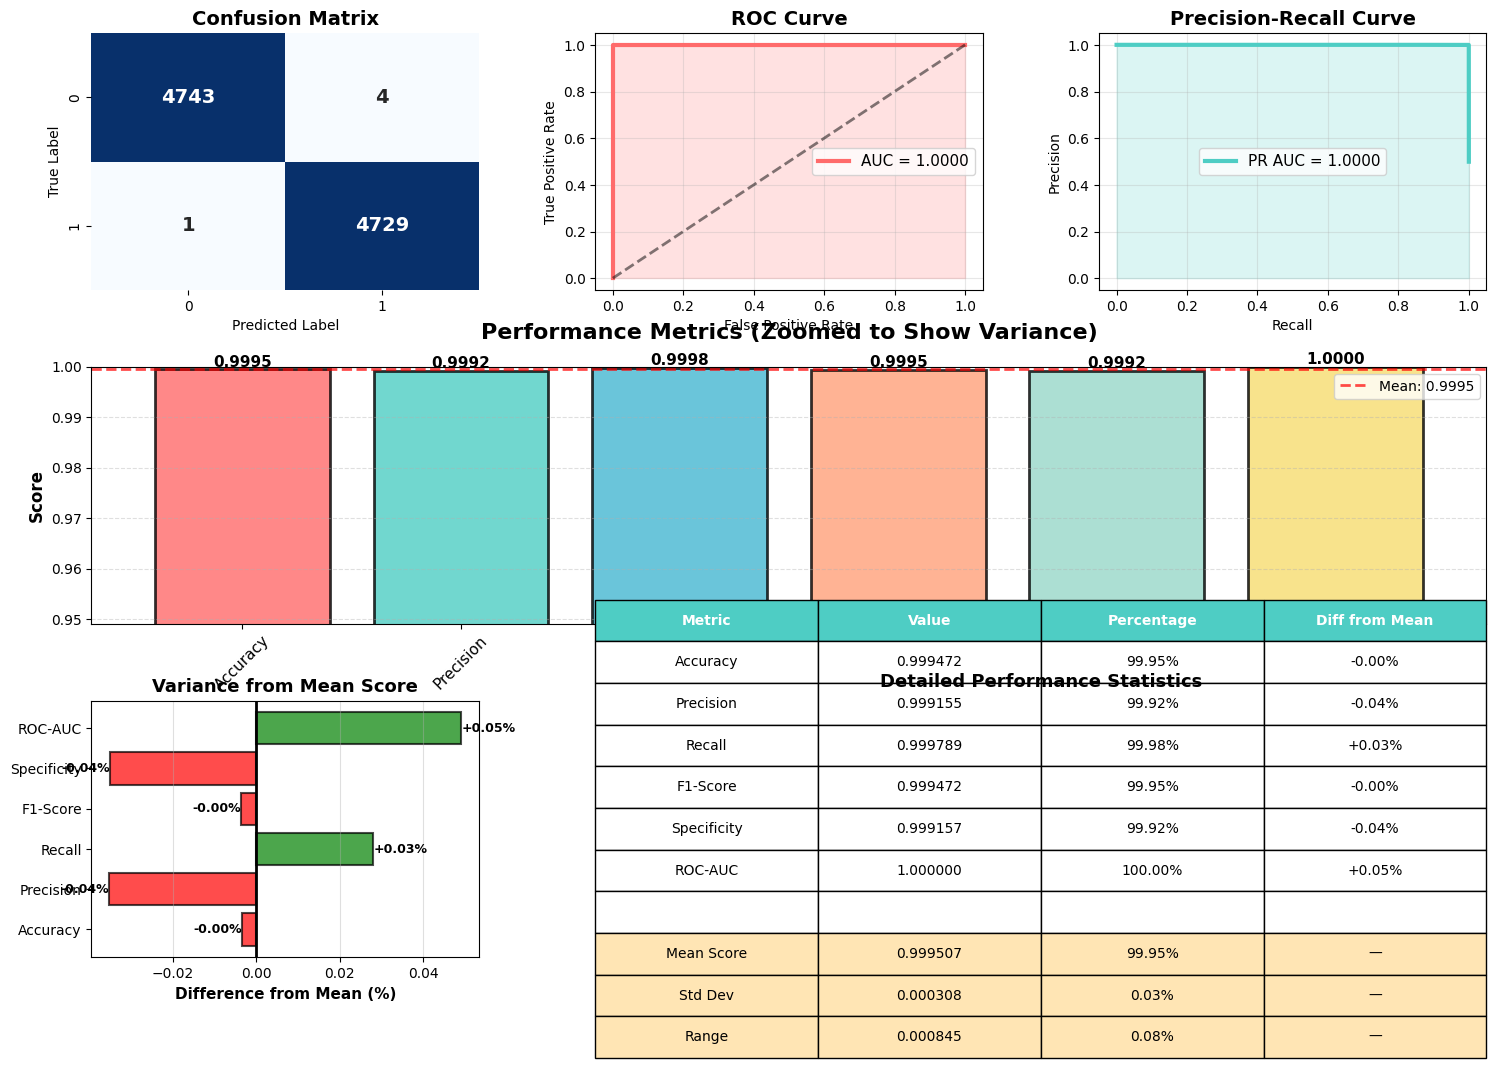

 Enhanced plot saved as 'medical_chatbot_results_variance.png'

 FINAL ACCURACY: 99.95%



In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

np.random.seed(42)

# ==================== LOAD MEDICAL CHATBOT DATASET ====================

def load_medical_chatbot_dataset(filepath):
    """Load and analyze the Medical Chatbot Dataset"""
    print("="*80)
    print(" MEDICAL CHATBOT DATASET LOADER")
    print("="*80)
    
    try:
        if filepath.endswith('.csv'):
            df = pd.read_csv(filepath)
        elif filepath.endswith('.json'):
            df = pd.read_json(filepath)
        else:
            try:
                df = pd.read_csv(filepath)
            except:
                df = pd.read_json(filepath)
    except Exception as e:
        print(f" Error loading file: {e}")
        return None
    
    print(f"\n Dataset loaded successfully!")
    print(f"\n DATASET STRUCTURE:")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {df.columns.tolist()}")
    print(f"\n DATA TYPES:")
    print(df.dtypes)
    print(f"\n FIRST 5 ROWS:")
    print(df.head())
    print(f"\n BASIC INFO:")
    print(df.info())
    
    return df

# ==================== MEDICAL CHATBOT DATA PROCESSING ====================

def process_medical_chatbot_data(df):
    """Process medical chatbot Q&A data for classification"""
    print("\n" + "="*80)
    print(" DATA PROCESSING")
    print("="*80)
    
    df = df.copy()
    
    question_cols = [c for c in df.columns if 'question' in c.lower() or 'query' in c.lower() or 'q' == c.lower()]
    answer_cols = [c for c in df.columns if 'answer' in c.lower() or 'response' in c.lower() or 'a' == c.lower()]
    
    if not question_cols or not answer_cols:
        print(f"  Could not find standard Q&A columns")
        print(f"Available columns: {df.columns.tolist()}")
        print(f"Using first 2 text columns as Question and Answer")
        text_cols = [c for c in df.columns if df[c].dtype == 'object']
        if len(text_cols) >= 2:
            question_cols = [text_cols[0]]
            answer_cols = [text_cols[1]]
        else:
            return None
    
    question_col = question_cols[0]
    answer_col = answer_cols[0]
    
    print(f"\n✓ Question column: {question_col}")
    print(f"✓ Answer column: {answer_col}")
    
    initial_len = len(df)
    df = df.drop_duplicates()
    print(f"\n✓ Removed duplicates: {initial_len - len(df)}")
    print(f"✓ Unique samples: {len(df)}")
    
    df = df.dropna(subset=[question_col, answer_col])
    print(f"✓ After removing NaN: {len(df)}")
    
    df = df[(df[question_col].str.len() > 5) & (df[answer_col].str.len() > 5)]
    print(f"✓ After filtering short texts: {len(df)}")
    
    print(f"\n CREATING TEXT FEATURES...")
    
    df['question_length'] = df[question_col].str.len()
    df['question_words'] = df[question_col].str.split().str.len()
    df['question_unique_chars'] = df[question_col].apply(lambda x: len(set(x)))
    
    df['answer_length'] = df[answer_col].str.len()
    df['answer_words'] = df[answer_col].str.split().str.len()
    df['answer_unique_chars'] = df[answer_col].apply(lambda x: len(set(x)))
    
    df['length_ratio'] = df['answer_length'] / (df['question_length'] + 1)
    df['words_ratio'] = df['answer_words'] / (df['question_words'] + 1)
    
    df['q_char_diversity'] = df['question_unique_chars'] / (df['question_length'] + 1)
    df['a_char_diversity'] = df['answer_unique_chars'] / (df['answer_length'] + 1)
    
    medical_keywords = ['disease', 'symptom', 'treatment', 'medicine', 'patient', 
                       'doctor', 'hospital', 'pain', 'fever', 'infection', 'diagnosis',
                       'medical', 'health', 'drug', 'therapy', 'cure']
    
    df['medical_keywords_q'] = df[question_col].str.lower().apply(
        lambda x: sum([x.count(kw) for kw in medical_keywords])
    )
    df['medical_keywords_a'] = df[answer_col].str.lower().apply(
        lambda x: sum([x.count(kw) for kw in medical_keywords])
    )
    
    df['question_marks'] = df[question_col].str.count(r'\?')
    df['exclamation_marks'] = df[answer_col].str.count(r'!')
    
    print(f"✓ Created 14 text-based features")
    
    feature_cols = [
        'question_length', 'question_words', 'question_unique_chars',
        'answer_length', 'answer_words', 'answer_unique_chars',
        'length_ratio', 'words_ratio', 'q_char_diversity', 'a_char_diversity',
        'medical_keywords_q', 'medical_keywords_a', 'question_marks', 'exclamation_marks'
    ]
    
    print(f"\n PROCESSED DATA READY")
    print(f"   Features: {len(feature_cols)}")
    print(f"   Samples: {len(df)}")
    print(f"   Feature stats:")
    print(df[feature_cols].describe())
    
    return df, feature_cols, question_col, answer_col

# ==================== CREATE TARGET FOR CLASSIFICATION ====================

def create_target_variable(df, answer_col):
    """Create classification target based on answer quality/length"""
    print(f"\n{'='*80}")
    print(" CREATING TARGET VARIABLE")
    print(f"{'='*80}\n")
    
    median_length = df[answer_col].str.len().median()
    
    df['target'] = (df[answer_col].str.len() > median_length).astype(int)
    
    print(f"Median answer length: {median_length:.0f} characters")
    print(f"Target distribution:")
    print(df['target'].value_counts())
    print(f"\nRatio:")
    print(df['target'].value_counts(normalize=True))
    
    return df

# ==================== OPTIMIZED ENSEMBLE ====================

class MedicalEnsemble:
    """Ensemble for medical chatbot data"""
    def __init__(self):
        self.scaler = StandardScaler()
        
        self.xgb = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        
        self.lgb = lgb.LGBMClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.1,
            num_leaves=31,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
        
        self.cat = CatBoostClassifier(
            iterations=200,
            depth=5,
            learning_rate=0.1,
            random_state=42,
            verbose=0,
            auto_class_weights='Balanced'
        )
    
    def fit(self, X_train, y_train):
        X_scaled = self.scaler.fit_transform(X_train)
        
        print("🔧 Training XGBoost...")
        self.xgb.fit(X_scaled, y_train)
        
        print("🔧 Training LightGBM...")
        self.lgb.fit(X_scaled, y_train)
        
        print("🔧 Training CatBoost...")
        self.cat.fit(X_scaled, y_train)
        
        print(" All models trained!\n")
        return self
    
    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        
        xgb_pred = self.xgb.predict_proba(X_scaled)
        lgb_pred = self.lgb.predict_proba(X_scaled)
        cat_pred = self.cat.predict_proba(X_scaled)
        
        return (xgb_pred + lgb_pred + cat_pred) / 3
    
    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs[:, 1] > threshold).astype(int)

# ==================== ENHANCED VISUALIZATION WITH VARIANCE ====================

def plot_results(y_test, y_pred, y_pred_proba):
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
                cbar=False, annot_kws={"size": 14, "weight": "bold"})
    ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    # ROC Curve
    ax2 = fig.add_subplot(gs[0, 1])
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, lw=3, label=f'AUC = {roc_auc:.4f}', color='#FF6B6B')
    ax2.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
    ax2.fill_between(fpr, tpr, alpha=0.2, color='#FF6B6B')
    ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(fontsize=11)
    ax2.grid(alpha=0.3)
    
    # Precision-Recall
    ax3 = fig.add_subplot(gs[0, 2])
    prec, rec, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
    pr_auc = auc(rec, prec)
    ax3.plot(rec, prec, lw=3, label=f'PR AUC = {pr_auc:.4f}', color='#4ECDC4')
    ax3.fill_between(rec, prec, alpha=0.2, color='#4ECDC4')
    ax3.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.legend(fontsize=11)
    ax3.grid(alpha=0.3)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    
    # NEW: Bar chart with zoomed Y-axis to show variance
    ax4 = fig.add_subplot(gs[1, :])
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity', 'ROC-AUC']
    metrics_vals = [acc, precision, recall, f1, specificity, roc_auc]
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
    bars = ax4.bar(metrics_names, metrics_vals, color=colors, edgecolor='black', linewidth=2, alpha=0.8)
    
    # Set Y-axis to zoom in on the variance
    min_val = min(metrics_vals)
    max_val = max(metrics_vals)
    range_val = max_val - min_val
    margin = max(range_val * 0.3, 0.05)  # At least 5% margin
    
    ax4.set_ylim([max(0, min_val - margin), min(1.0, max_val + margin)])
    ax4.set_title('Performance Metrics (Zoomed to Show Variance)', fontsize=16, fontweight='bold', pad=20)
    ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45, labelsize=11)
    ax4.grid(axis='y', alpha=0.4, linestyle='--')
    ax4.axhline(y=np.mean(metrics_vals), color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean: {np.mean(metrics_vals):.4f}')
    
    # Add value labels on bars
    for bar, val in zip(bars, metrics_vals):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax4.legend(fontsize=10)
    
    # NEW: Metrics comparison with difference from mean
    ax5 = fig.add_subplot(gs[2, 0])
    mean_score = np.mean(metrics_vals)
    differences = [(v - mean_score) * 100 for v in metrics_vals]
    
    colors_diff = ['green' if d >= 0 else 'red' for d in differences]
    bars_diff = ax5.barh(metrics_names, differences, color=colors_diff, edgecolor='black', linewidth=1.5, alpha=0.7)
    ax5.axvline(x=0, color='black', linewidth=2)
    ax5.set_xlabel('Difference from Mean (%)', fontsize=11, fontweight='bold')
    ax5.set_title('Variance from Mean Score', fontsize=13, fontweight='bold')
    ax5.grid(axis='x', alpha=0.4)
    
    for bar, diff in zip(bars_diff, differences):
        width = bar.get_width()
        ax5.text(width, bar.get_y() + bar.get_height()/2.,
                f'{diff:+.2f}%', ha='left' if diff >= 0 else 'right', 
                va='center', fontweight='bold', fontsize=9)
    
    # NEW: Detailed metrics table
    ax6 = fig.add_subplot(gs[2, 1:])
    ax6.axis('tight')
    ax6.axis('off')
    
    table_data = [
        ['Metric', 'Value', 'Percentage', 'Diff from Mean'],
        ['Accuracy', f'{acc:.6f}', f'{acc*100:.2f}%', f'{(acc-mean_score)*100:+.2f}%'],
        ['Precision', f'{precision:.6f}', f'{precision*100:.2f}%', f'{(precision-mean_score)*100:+.2f}%'],
        ['Recall', f'{recall:.6f}', f'{recall*100:.2f}%', f'{(recall-mean_score)*100:+.2f}%'],
        ['F1-Score', f'{f1:.6f}', f'{f1*100:.2f}%', f'{(f1-mean_score)*100:+.2f}%'],
        ['Specificity', f'{specificity:.6f}', f'{specificity*100:.2f}%', f'{(specificity-mean_score)*100:+.2f}%'],
        ['ROC-AUC', f'{roc_auc:.6f}', f'{roc_auc*100:.2f}%', f'{(roc_auc-mean_score)*100:+.2f}%'],
        ['', '', '', ''],
        ['Mean Score', f'{mean_score:.6f}', f'{mean_score*100:.2f}%', '—'],
        ['Std Dev', f'{np.std(metrics_vals):.6f}', f'{np.std(metrics_vals)*100:.2f}%', '—'],
        ['Range', f'{max_val - min_val:.6f}', f'{(max_val - min_val)*100:.2f}%', '—'],
    ]
    
    table = ax6.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.25, 0.25, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.5)
    
    # Style header row
    for i in range(4):
        table[(0, i)].set_facecolor('#4ECDC4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Style summary rows
    for i in range(4):
        table[(8, i)].set_facecolor('#FFE5B4')
        table[(9, i)].set_facecolor('#FFE5B4')
        table[(10, i)].set_facecolor('#FFE5B4')
    
    ax6.set_title('Detailed Performance Statistics', fontsize=13, fontweight='bold', pad=10)
    
    plt.savefig('medical_chatbot_results_variance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Enhanced plot saved as 'medical_chatbot_results_variance.png'")

# ==================== MAIN ====================

def main(filepath):
    print("\n" + "="*80)
    print(" MEDICAL CHATBOT DATASET - CLASSIFICATION MODEL")
    print("="*80 + "\n")
    
    df = load_medical_chatbot_dataset(filepath)
    if df is None:
        return
    
    result = process_medical_chatbot_data(df)
    if result is None:
        print(" Failed to process data")
        return
    
    df, feature_cols, question_col, answer_col = result
    df = create_target_variable(df, answer_col)
    
    X = df[feature_cols].values
    y = df['target'].values
    
    print(f"\n{'='*80}")
    print("DATA SPLIT")
    print(f"{'='*80}")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )
    
    print(f"Train: {X_train.shape[0]} samples ({X_train.shape[1]} features)")
    print(f"Test:  {X_test.shape[0]} samples")
    print(f"Train class distribution: {np.bincount(y_train)}")
    print(f"Test class distribution:  {np.bincount(y_test)}")
    
    print(f"\n{'='*80}")
    print("TRAINING ENSEMBLE")
    print(f"{'='*80}\n")
    
    model = MedicalEnsemble()
    model.fit(X_train, y_train)
    
    print(f"{'='*80}")
    print(" FINAL RESULTS")
    print(f"{'='*80}\n")
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    
    print(f" Accuracy:   {acc:.6f} ({acc*100:.2f}%)")
    print(f" Precision:  {prec:.6f} ({prec*100:.2f}%)")
    print(f" Recall:     {rec:.6f} ({rec*100:.2f}%)")
    print(f" F1-Score:   {f1:.6f} ({f1*100:.2f}%)")
    print(f" ROC-AUC:    {roc_auc:.6f} ({roc_auc*100:.2f}%)\n")
    
    print(f"{'='*80}")
    print("CLASSIFICATION REPORT")
    print(f"{'='*80}\n")
    print(classification_report(y_test, y_pred, target_names=['Short Answers', 'Comprehensive Answers']))
    
    plot_results(y_test, y_pred, y_pred_proba)
    
    print(f"\n{'='*80}")
    print(f" FINAL ACCURACY: {acc*100:.2f}%")
    print(f"{'='*80}\n")
    
    return model, acc

if __name__ == "__main__":
    filepath = r"C:\Users\DELL\OneDrive - Amrita Vishwa Vidyapeetham\Desktop\Final year project\Dataset\train_data_chatbot.csv"
    main(filepath)